# CL04 - Projet P24

Dans le cadre de l'UE CL04, nous effectuons des simulations sur le stock d'un magasin, afin d'évaluer le résultat en fonction 

## Import des données et librairies

Dans un premier temps, nous allons importer les différentes librairies utilisées pour la suite :



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join

Ensuite, nous allons utiliser les 7 fichiers générés par les fichier stock_simulation.py et add_cost.py, pour répondre aux différentes questions.

In [3]:
path = "G:\\Mon Drive\\COURS\\GI06\\IF29\\Stock_Simulation\\Export_stp2"
files = [f for f in listdir(path) if isfile(join(path, f))]
display(files)

['STP2_CL04_export_1000_K10.csv',
 'STP2_CL04_export_1000_K00.csv',
 'STP2_CL04_export_1000_K20.csv',
 'STP2_CL04_export_1000_K30.csv',
 'STP2_CL04_export_1000_K40.csv',
 'STP2_CL04_export_1000_K50.csv',
 'STP2_CL04_export_1000_K60.csv']

### Paramètres valeurs

In [4]:
lambda1 = 15 #Commande hors ligne
lambda2 = 30 #Commande en ligne
L = 1 #Délai de livraison approvisionnement
W=1 # Délai acceptable pour une commande en ligne
F=18 #Cout de passation de commande
h = 0.05 #Cout de stockage
p = 20 #Cout de perte unitaire
b = 5 #Indemnité de retard
Q = 180 #Quantité de commande
r = 60 #Point de recommande

Pour comprendre la suite, nous allons tout d'abord décrire les colonnes qui seront utilisés par la suite.

In [5]:
#Put table in Pandas DataFrame
K10_timeline = pd.read_csv(path + "\\"+files[0],index_col=0)
display(K10_timeline.head())

,time,event_type,stock,attente,perte_magasin,deliv,late_cost,passation_cost,Time_gap,stock_cost,Loss_cost,Total_cost,Cum_cost,mean_cost
0,0.000000,0,60,0,0,0,0.0,0,0.013976,0.041928,0,0.041928,0.041928,inf
1,0.013976,2,59,0,0,1,0.0,0,0.000028,0.000084,0,0.000084,0.042012,3.006014
2,0.014004,2,58,0,0,1,0.0,0,0.040593,0.117719,0,0.117719,0.159731,11.405751
3,0.054597,2,57,0,0,1,0.0,0,0.024283,0.069208,0,0.069208,0.228939,4.193223
4,0.078881,2,56,0,0,1,0.0,0,0.014046,0.039329,0,0.039329,0.268268,3.400930


## Calcul des indicateurs de performance pour les paramètres de bases.

Par défaut, le paramètre de priorisation K vaut 10, et c'est avec cette valeur que nous allons étudier l'évolution du stock (fichier STP2_CL04_export_1000_K10.csv )

Les premiers indicateurs à étudier sont le niveau moyen de stock, le pourcentage de perte de commande en magasin, le pourcentage de commande en retard et le cout moyen total du stock. 

In [6]:
#Niveau moyen de stock
stock_avg = sum(K10_timeline["stock"]*K10_timeline["Time_gap"])/K10_timeline.time.max()
print("Le niveau de stock moyen vaut : ",stock_avg)
#Perte en magasin
total_magasin = K10_timeline.where(K10_timeline.event_type == 1).deliv.count()
perte_magasin = K10_timeline.where(K10_timeline.event_type == 1).perte_magasin.sum()
perte_mag_ratio = perte_magasin/total_magasin
print("Le pourcentage de perte sur le magasin vaut : ",perte_mag_ratio)
#Attente en ligne
total_ligne = K10_timeline.where(K10_timeline.event_type == 2).deliv.count()
perte_ligne = K10_timeline.where(K10_timeline.event_type == 2).where(K10_timeline.deliv == 0).deliv.count()
perte_ligne_ratio = perte_ligne/total_ligne
print("Le pourcentage d'attente en ligne vaut : ",perte_ligne_ratio)
#Cout total moyen 
avg_total_cost = K10_timeline.iloc[-1].mean_cost
print("Le cout moyen vaut : ",avg_total_cost)

Le niveau de stock moyen vaut :  103.80994024283368
Le pourcentage de perte sur le magasin vaut :  0.005146557600545331
Le pourcentage d'attente en ligne vaut :  0.007000804882956603
Le cout moyen vaut :  11.257575676574929


Pour comprendre plus en détail le fonctionnement, nous pouvons faire un focus sur une période de quelques approvisionnement pour voir l'évolution du stock.

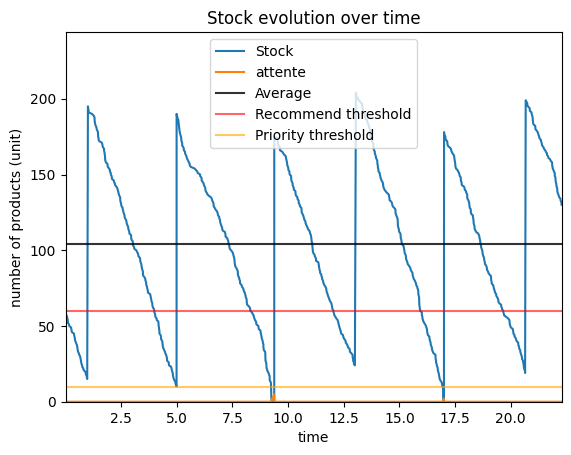

In [7]:
Timeline = K10_timeline.loc[1:1000]
K = 10

def line_plot(x,serie,col="black",al=1 ,lab = ""):
    plt.plot([0,max(serie)],[x,x],c=col,alpha = al,label = lab)

#Plot the stock
plt.plot(Timeline.time, Timeline.stock,label = "Stock")
plt.plot(Timeline.time, Timeline.attente,label = "attente")
line_plot(stock_avg,Timeline.time,"black",0.8,"Average")
line_plot(r,Timeline.time,"red",0.6,"Recommend threshold")
line_plot(K,Timeline.time,"orange",0.6,"Priority threshold")
plt.title("Stock evolution over time")
plt.xlim(min(Timeline.time),max(Timeline.time))
plt.ylim(min(Timeline.stock),max(Timeline.stock)+40)
plt.ylabel("number of products (unit)")
plt.xlabel("time")
plt.legend()
plt.show()

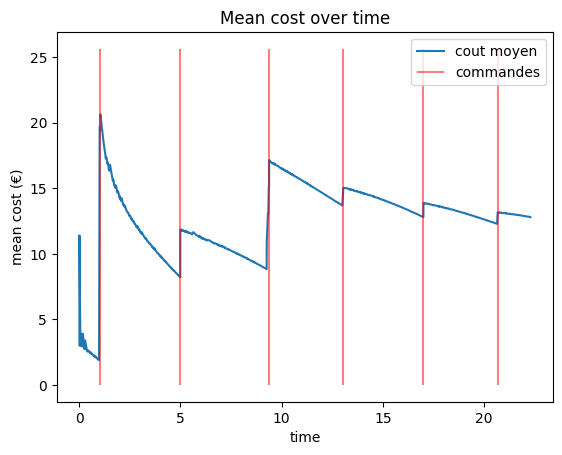

In [8]:
#Plot the cost
cmd_time = Timeline.where(Timeline.event_type == 3).time
plt.plot(Timeline.time,Timeline.mean_cost,label = "cout moyen")
plt.title("Mean cost over time")
plt.vlines(cmd_time,0,max(Timeline.mean_cost)+5,colors="red",alpha = 0.5,label = "commandes")
plt.ylabel("mean cost (€)")
plt.xlabel("time")
plt.legend()
plt.show()

## Etudes en faisant évoluer la valeur de K 

Mise en forme des données

In [22]:
Results = pd.DataFrame(columns = ["K","stock_avg","total_mag","perte_mag","ratio_mag","total_ligne","perte_ligne","ratio_ligne","avg_total_cost"])

def indicat(f):
    T = pd.read_csv(path + "\\"+f,index_col=0)
    temp = np.full(9,0.)
    #Obtain K
    a = f.find("K")
    b = f[a+1:a+3]
    temp[0] = int(b)
    #Niveau moyen de stock
    temp[1] = sum(T["stock"]*T["Time_gap"])/T.time.max()
    #Perte en magasin
    temp[2] = T.where(T.event_type == 1).deliv.count()
    temp[3] = T.where(T.event_type == 1).perte_magasin.sum()
    temp[4] = temp[3]/temp[2]
    #Attente en ligne
    temp[5] = T.where(T.event_type == 2).deliv.count()
    temp[6] = T.where(T.event_type == 2).where(T.deliv == 0).deliv.count()
    temp[7] = temp[6]/temp[5]
    #Cout total moyen 
    temp[8] = T.iloc[-1].mean_cost
    #Return
    return temp

for i,f in enumerate(files) :
    A = indicat(f)
    Results.loc[i] = A
Results.sort_values("K",inplace=True)
display(Results)
    

,K,stock_avg,total_mag,perte_mag,ratio_mag,total_ligne,perte_ligne,ratio_ligne,avg_total_cost
1,0.0,104.429622,60027.0,16.0,0.000267,119846.0,18.0,0.000150,9.813647
0,10.0,103.809940,58680.0,302.0,0.005147,119272.0,835.0,0.007001,11.257576
2,20.0,97.733406,55697.0,1983.0,0.035603,111101.0,4564.0,0.041080,20.396278
3,30.0,90.346201,52014.0,5014.0,0.096397,103610.0,10560.0,0.101921,38.703630
4,40.0,84.548460,49419.0,8068.0,0.163257,99015.0,17321.0,0.174933,58.624500
5,50.0,77.893261,47297.0,11358.0,0.240142,94459.0,23953.0,0.253581,81.535740
6,60.0,69.990342,45160.0,14902.0,0.329982,90138.0,30922.0,0.343052,109.039100


Etude des données

In [ ]:
#Stock Average
plt.plot(Results.K,Results.stock_avg,label="stock moyen")
plt.title("Stock average by K")
plt.legend()
plt.show()
#% perte mag
plt.plot(Results.K,Results.ratio_mag*100,label="ratio mag")
plt.ylim=(0,100)
plt.title("Stock average by K")
plt.legend()
plt.show()

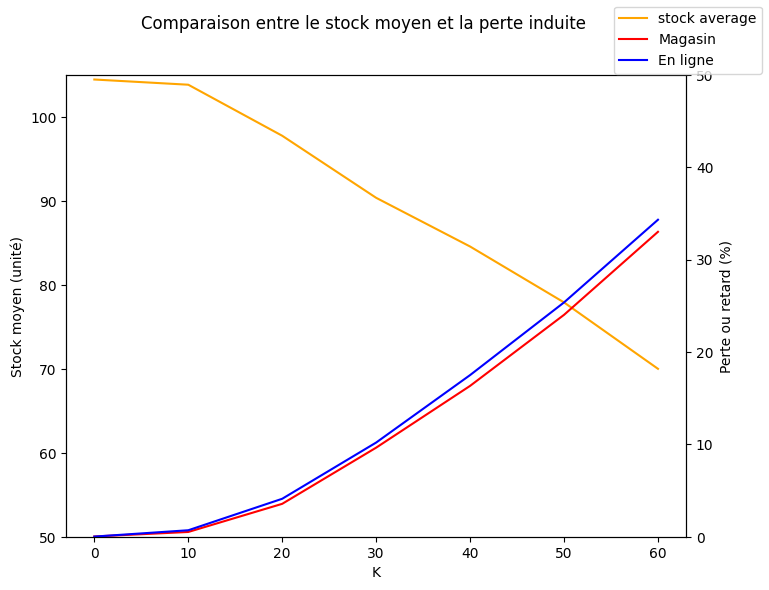

In [46]:
fig, ax1 = plt.subplots(figsize=(8, 6))
fig.suptitle("Comparaison entre le stock moyen et la perte induite ")
#Axe 2
ax1.plot(Results.K,Results.stock_avg,c="orange",label="stock average")
ax1.set_ylim(50,105)
ax1.set_ylabel("Stock moyen (unité)")
#Axe 2
ax2 = ax1.twinx()  
ax2.set_ylim(0, 50)
ax2.plot(Results.K,Results.ratio_mag*100,c = "red",label = "Magasin")
ax2.plot(Results.K,Results.ratio_ligne*100,c="blue",label="En ligne")
ax2.set_ylabel("Perte ou retard (%)")
#Global fig
ax1.set_xlabel("K")
fig.legend()

On peut voir qu'au .........